# 8th compressive sampling (sensing) / network tomography workbook
### Implement Toy Model 1 from Hazelton(2015) with algorithm from Dey, et al.
- Subrasankha Dey, Stephen Winter and Martin Tomko, Origing-Destination Flow Estimation from Link Count Data Only, Sensors 2020, 20, 5226.

- Corrects errors in Compressed_Sensing_6!

# Next project get a working EM/MLE for Poisson and then negative Binomial!
### Use SGD and regularization terms
-   use part of the Y time slices in a large sample to estimate the Poisson / NB and regularization parameters
-   generate a large sample of X's with these parameters
-   consider a variable for day of week, time of day
-   run the Y=AX to generate new Y's from the generated X's to essentially "Test" the model
-   gather statistics on goodness-of-fit from this test
### Use PCA if needed
# Then use a neural network
# Then do it on the data from UTD19
# Then implement CGAME



@article{diamond2016cvxpy,
  author  = {Steven Diamond and Stephen Boyd},
  title   = {{CVXPY}: {A} {P}ython-embedded modeling language for convex optimization},
  journal = {Journal of Machine Learning Research},
  year    = {2016},
  volume  = {17},
  number  = {83},
  pages   = {1--5},
}

# Use final_project environment
-cvxpy
-osmnx
-pytorch
-geopandas

In [1]:
import numpy as np
import cvxpy as cvx
import geopandas as gp
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
import os
import errno
data_dir = "../"
print("Data directory ",data_dir)
path = os.path.join(data_dir,"output")

try:
    os.mkdir(path)
except OSError as exc:
    if exc.errno != errno.EEXIST:
        raise
    pass
print("Created directory "+path)

Data directory  ../
Created directory ../output


# Example 1 from Figure 4 in Hazelton(2015): London Road in Leicester
- Four nodes in a "T" format
- The three nodes at the end of the "T" are origins and destinations: node "2" is not
- Six edges
- Five edges have counters with data in five time periods.
- There is only one route for each OD pair (6 total)
- <i>This obviates the need for prior knowledge about the routing or OD matrix that is otherwise required to start the algorithm</i>
- Find the trip production at the origins and the trip arrivals at the destinations (OD matrix)
- Find the counts on the uncounted edge in all 5 time periods

In [3]:
nodes=[1,2,3,4]# node names
edges=[1,2,3,4,5,6]#edge names
edge_uv=[(1,2),(2,1),(2,3),(3,2),(2,4),(4,2)]# node names u,v
edge_weights=[1.0,1.0,1.0,1.0,1.0,1.0]
edge_weights_dict=dict(zip(edge_uv,edge_weights))
edge_labels_dict = dict(zip(edges, edge_uv))
node_xy=[(0,1),(1,1),(1,0),(2,1)]
node_xy_dict=dict(zip(nodes,node_xy))

In [4]:
edge_weights_dict

{(1, 2): 1.0, (2, 1): 1.0, (2, 3): 1.0, (3, 2): 1.0, (2, 4): 1.0, (4, 2): 1.0}

In [5]:
edge_labels_dict

{1: (1, 2), 2: (2, 1), 3: (2, 3), 4: (3, 2), 5: (2, 4), 6: (4, 2)}

In [6]:
node_xy_dict

{1: (0, 1), 2: (1, 1), 3: (1, 0), 4: (2, 1)}

# Make a networkx object of the graph

In [7]:
G=nx.DiGraph()
G.graph["name"]="Model 1 Hazelton(2015)"
G.add_nodes_from(nodes)
nx.set_node_attributes(G,node_xy_dict,name="pos")
G.add_edges_from(edge_uv)#add_weighted_edges_from (3,1,5.493) tuple u,v,weight
nx.set_edge_attributes(G,edge_weights_dict,name="weight")
print(G.number_of_nodes(), G.number_of_edges())
print(list(G.nodes))
print(list(G.edges))
#G.adj.items#
#G.edges.data# for (u, v, wt) in FG.edges.data('weight'):
print(list(G.neighbors(2)))

4 6
[1, 2, 3, 4]
[(1, 2), (2, 1), (2, 3), (2, 4), (3, 2), (4, 2)]
[1, 3, 4]


In [8]:
print(nx.get_node_attributes(G,"pos"))

{1: (0, 1), 2: (1, 1), 3: (1, 0), 4: (2, 1)}


# Plot only shows weights of one link if links are parallel
- for better plots use graphvis or ox

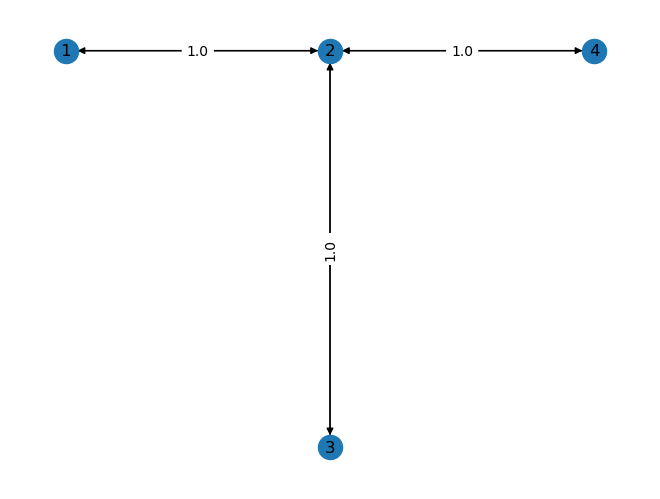

In [9]:
pos=nx.get_node_attributes(G,"pos")
nx.draw(G,pos,with_labels=True)
labels = nx.get_edge_attributes(G,"weight")
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
plt.savefig(path+"/HazeltonModel1Network")

#subax2=plt.subplot(122)
#nx.draw_shell(G, nlist=[range(5, 10), range(5)], with_labels=True, font_weight='bold')

In [10]:
print(nx.get_edge_attributes(G,"weight"))

{(1, 2): 1.0, (2, 1): 1.0, (2, 3): 1.0, (2, 4): 1.0, (3, 2): 1.0, (4, 2): 1.0}


In [11]:
# Original Model 1
counts=np.zeros((5,5))# rows are links with counts, columns are counts in a time interval
counts[0,:]=[255,190,220,190,235]# edge 1
#counts[1,:]=[75,78,80,77,75]# no counts for edge 2
counts[1,:]=[235,185,180,160,195]# edge 3
counts[2,:]=[210,165,190,200,195]# edge 4
counts[3,:]=[56,42,48,56,56]# edge 5
counts[4,:]=[72,74,84,80,72]# edge 6
edges_w_counts=[1,3,4,5,6]

In [12]:
#counts=np.zeros((6,5))# rows are links with counts, columns are counts in a time interval
#counts[0,:]=[255,190,220,190,235]# edge 1
#counts[1,:]=[85,78,80,77,79]# no counts for edge 2
#counts[2,:]=[235,181,186,176,195]# edge 3
#counts[3,:]=[210,165,180,175,190]# edge 4
#counts[4,:]=[56,42,48,56,58]# edge 5
#counts[5,:]=[78,74,87,80,83]# edge 6
#edges_w_counts=[1,2,3,4,5,6]

In [13]:
countkeys=[]
for idx in edges_w_counts:
    countkeys.append(edge_labels_dict[idx])
counts_dict=dict(zip(countkeys,counts[:,:]))

In [14]:
print(countkeys)

[(1, 2), (2, 3), (3, 2), (2, 4), (4, 2)]


In [15]:
counts_dict

{(1, 2): array([255., 190., 220., 190., 235.]),
 (2, 3): array([235., 185., 180., 160., 195.]),
 (3, 2): array([210., 165., 190., 200., 195.]),
 (2, 4): array([56., 42., 48., 56., 56.]),
 (4, 2): array([72., 74., 84., 80., 72.])}

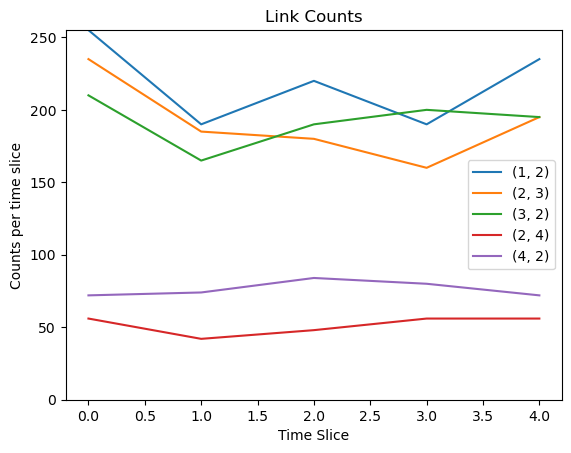

In [16]:
import matplotlib.pyplot as plt
x=list(range(0,counts.shape[1]))
for ii in range(counts.shape[0]):
    plt.plot(x,counts[ii,:],label=str(list(counts_dict.keys())[ii]))
plt.ylim(0,np.max(counts))
plt.xlabel("Time Slice")
plt.ylabel("Counts per time slice")
plt.legend()
plt.title("Link Counts")
plt.savefig(path+"/HazeltonModel1LinkCounts")
plt.show()

# Routes between O's and D's.
- one list of routes as edge sequences
- one list of routes as node sequences
- note that a dict of OD_pairs to routes must accomodate several routes per OD_pair later on
    - the "zip" can be replaced by an iterator over OD_Pairs, add a list of routes to the OD_Pair key

# $O, D$

In [17]:
origins=nodes
destinations=nodes
od_pairs=[]
for o in origins:
   if(o != 2):
    for d in nx.dfs_postorder_nodes(G,source=o):
        if(d!=2):
            if(o!=d):
              od_pairs.append((o,d))
print(od_pairs)
print(len(od_pairs))

[(1, 3), (1, 4), (3, 1), (3, 4), (4, 1), (4, 3)]
6


In [18]:
od_route_n_dict={}
od_route_e_dict={}

In [19]:
# routes as sequence of nodes
routes_n=[]
routes_e=[]
for od in od_pairs:
    rnlist=list(nx.all_simple_paths(G,od[0],od[1]))
    od_route_n_dict[od]=rnlist
    routes_n.append(rnlist)
    relist=list(nx.all_simple_edge_paths(G,od[0],od[1]))
    od_route_e_dict[od]=relist
    routes_e.append(relist)

In [20]:
len(routes_e)

6

In [21]:
od_route_n_dict

{(1, 3): [[1, 2, 3]],
 (1, 4): [[1, 2, 4]],
 (3, 1): [[3, 2, 1]],
 (3, 4): [[3, 2, 4]],
 (4, 1): [[4, 2, 1]],
 (4, 3): [[4, 2, 3]]}

In [22]:
od_route_e_dict

{(1, 3): [[(1, 2), (2, 3)]],
 (1, 4): [[(1, 2), (2, 4)]],
 (3, 1): [[(3, 2), (2, 1)]],
 (3, 4): [[(3, 2), (2, 4)]],
 (4, 1): [[(4, 2), (2, 1)]],
 (4, 3): [[(4, 2), (2, 3)]]}

In [23]:
od_route_names_dict={}
route_names=[]
for od in od_pairs:
    od_route_names=[]
    for i in range(0,len(od_route_n_dict[od])):
        string=((od[0],od[1],str(i)))
        od_route_names.append(string)
        route_names.append(string)
    od_route_names_dict[od]=tuple(od_route_names)


In [24]:
route_names

[(1, 3, '0'), (1, 4, '0'), (3, 1, '0'), (3, 4, '0'), (4, 1, '0'), (4, 3, '0')]

In [25]:
len(route_names)

6

In [26]:
od_route_names_dict

{(1, 3): ((1, 3, '0'),),
 (1, 4): ((1, 4, '0'),),
 (3, 1): ((3, 1, '0'),),
 (3, 4): ((3, 4, '0'),),
 (4, 1): ((4, 1, '0'),),
 (4, 3): ((4, 3, '0'),)}

### Have to flatten the routes_e and routes_n lists in order to assign them to route_names

In [27]:
def flatten(l):
    return [item for sublist in l for item in sublist]

In [28]:
print(len(flatten(routes_e)))

6


In [29]:
# dict of origins and routes
routes_e_dict=dict(zip(route_names,flatten(routes_e)))# route names, edge sequence (tuple u,v)
routes_n_dict=dict(zip(route_names,flatten(routes_n)))# route names, node sequence (u)

In [30]:
routes_e_dict

{(1, 3, '0'): [(1, 2), (2, 3)],
 (1, 4, '0'): [(1, 2), (2, 4)],
 (3, 1, '0'): [(3, 2), (2, 1)],
 (3, 4, '0'): [(3, 2), (2, 4)],
 (4, 1, '0'): [(4, 2), (2, 1)],
 (4, 3, '0'): [(4, 2), (2, 3)]}

In [31]:
routes_n_dict

{(1, 3, '0'): [1, 2, 3],
 (1, 4, '0'): [1, 2, 4],
 (3, 1, '0'): [3, 2, 1],
 (3, 4, '0'): [3, 2, 4],
 (4, 1, '0'): [4, 2, 1],
 (4, 3, '0'): [4, 2, 3]}

In [32]:
edge_labels_dict

{1: (1, 2), 2: (2, 1), 3: (2, 3), 4: (3, 2), 5: (2, 4), 6: (4, 2)}

In [33]:
# route costs
routes_c_dict={}
for rn in route_names:
    es=routes_e_dict[rn]
    lc=[]
    for e in es:
        c=edge_weights_dict[e]
        lc.append(c)
    routes_c_dict[rn]=lc
print(routes_c_dict)

{(1, 3, '0'): [1.0, 1.0], (1, 4, '0'): [1.0, 1.0], (3, 1, '0'): [1.0, 1.0], (3, 4, '0'): [1.0, 1.0], (4, 1, '0'): [1.0, 1.0], (4, 3, '0'): [1.0, 1.0]}


# Adjacency matrix (link-path incidence matrix) A=aij
- counted edges/links versus routes they are on
- 0,1 definition used by Vardi(1996) and Hazelton(2015)
- Make into a function
- This should be OD relations to the right and not routes
    - if there are more than 1 routes per OD relation this code has to be fixed, see later on
- It's still a valuable mapping to have

In [34]:
# a_ij = 1 if link i is in route j, 0 otherwise
I=len(counts_dict)#7
J=len(routes_e)#16
aij=np.zeros((I, J))
for i in range(I):
    for j in range(J):
        for k in range(len(routes_e[j])):
            print(routes_e[j][k])
            print(list(counts_dict.keys())[i])
            if(routes_e[j][k]==list(counts_dict.keys())[i]):
                aij[i,j]=1

[(1, 2), (2, 3)]
(1, 2)
[(1, 2), (2, 4)]
(1, 2)
[(3, 2), (2, 1)]
(1, 2)
[(3, 2), (2, 4)]
(1, 2)
[(4, 2), (2, 1)]
(1, 2)
[(4, 2), (2, 3)]
(1, 2)
[(1, 2), (2, 3)]
(2, 3)
[(1, 2), (2, 4)]
(2, 3)
[(3, 2), (2, 1)]
(2, 3)
[(3, 2), (2, 4)]
(2, 3)
[(4, 2), (2, 1)]
(2, 3)
[(4, 2), (2, 3)]
(2, 3)
[(1, 2), (2, 3)]
(3, 2)
[(1, 2), (2, 4)]
(3, 2)
[(3, 2), (2, 1)]
(3, 2)
[(3, 2), (2, 4)]
(3, 2)
[(4, 2), (2, 1)]
(3, 2)
[(4, 2), (2, 3)]
(3, 2)
[(1, 2), (2, 3)]
(2, 4)
[(1, 2), (2, 4)]
(2, 4)
[(3, 2), (2, 1)]
(2, 4)
[(3, 2), (2, 4)]
(2, 4)
[(4, 2), (2, 1)]
(2, 4)
[(4, 2), (2, 3)]
(2, 4)
[(1, 2), (2, 3)]
(4, 2)
[(1, 2), (2, 4)]
(4, 2)
[(3, 2), (2, 1)]
(4, 2)
[(3, 2), (2, 4)]
(4, 2)
[(4, 2), (2, 1)]
(4, 2)
[(4, 2), (2, 3)]
(4, 2)


In [35]:
I=len(countkeys)
J=len(route_names)
aij=np.zeros((I,J))
i=0
for e in countkeys:#I
    j=0
    for rn in route_names:#J
        rs=routes_e_dict[rn]
        for r in rs:
#            print(i,j,e,r)
            if(e == r):
                aij[i,j]=1
        j+=1
    i+=1
        

In [36]:
aij# each column is a route between an OD pair J and each row has 1 if a link I is on the route

array([[1., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 1.],
       [0., 0., 1., 1., 0., 0.],
       [0., 1., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 1.]])

# Matrix of all edges which are on routes a2ij
- Map of all edges/links and the routes they are on
- 0,1
- Use to calculate the flows on non-measured links along the routes
- After the OD flows are calculated

In [37]:
edge_labels_dict.values()

dict_values([(1, 2), (2, 1), (2, 3), (3, 2), (2, 4), (4, 2)])

In [38]:
I=len(edge_labels_dict.keys())
J=len(route_names)
a2ij=np.zeros((I,J))
pi1=np.zeros((I,J))
i=0
for e in edge_labels_dict.values():#I
    j=0
    for rn in route_names:#J
        rs=routes_e_dict[rn]
        for r in rs:
#            print(i,j,e,r)
            if(e == r):
                a2ij[i,j]=1
                pi1[i,j]=edge_weights[i]
        j+=1
    i+=1

In [39]:
a2ij

array([[1., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 1., 0.],
       [1., 0., 0., 0., 0., 1.],
       [0., 0., 1., 1., 0., 0.],
       [0., 1., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 1.]])

### For each time slice, Y is counts (dim m x 1) = A (dim m x n) * X (dim n x 1), m<n .
- Need to find X the OD flow
- m is the number of edges with counts on them
- n is the number of routes between OD
- dimension 1 becomes K for K time slices

In [40]:
print(aij.shape, counts.shape)

(5, 6) (5, 5)


# Model 5 days of made-up data on 7 (all links) measured links for all 16 routes (each OD pair has different number of routes). Flows are per route, not per OD

- Hazelton (2015) must use a survey of OD traffic to generate initial x flows using a Gamma function of parameters (x_survey/2, 1/2). How does he use these in the solution?

- The following is solved using ECOS_BB in the package cvxpy

### We need integer-value results and use a special included mixed-integer solver

In [41]:
# y = Ax
# We have y and A and want x
# y is m x 1; A is m x n; x is n x 1; m = 5, n = 6
x = cvx.Variable((aij.shape[1],counts.shape[1]),integer=True)

#err = cvx.abs(aij @ x - counts)
err = cvx.sum_squares(aij @ x - counts)
objective = cvx.Minimize(cvx.norm(err,1))# regularize later with sum(w*aij) see Kurzhanskiy
constraints = [x >= 0 ]
prob = cvx.Problem(objective, constraints)

# The optimal objective is returned by prob.solve().
result = prob.solve(solver="ECOS_BB")

# The optimal value for x is stored in x.value.
print("The flows on the routes (one route per row) in the time slices (one time slice per column)")
print(x.value)

The flows on the routes (one route per row) in the time slices (one time slice per column)
[[216. 164. 176. 147. 187.]
 [ 39.  26.  44.  43.  48.]
 [193. 149. 186. 187. 187.]
 [ 17.  16.   4.  13.   8.]
 [ 53.  53.  80.  67.  64.]
 [ 19.  21.   4.  13.   8.]]


In [42]:
print(np.mean(x.value,axis=1))

[178.   40.  180.4  11.6  63.4  13. ]


In [43]:
print("The flows on each edge (one edge per row) (one time slice per column")
print("NOTE that all flows equal counts and that edge 5 flows have been imputed by the algorithm")
np.dot(a2ij,x.value)

The flows on each edge (one edge per row) (one time slice per column
NOTE that all flows equal counts and that edge 5 flows have been imputed by the algorithm


array([[255., 190., 220., 190., 235.],
       [246., 202., 266., 254., 251.],
       [235., 185., 180., 160., 195.],
       [210., 165., 190., 200., 195.],
       [ 56.,  42.,  48.,  56.,  56.],
       [ 72.,  74.,  84.,  80.,  72.]])

### The average values of link flows for all 6 links matches Hazelton (2015) Table 1
- Standard deviations are different but between those of Hazelton's negative binomial and poisson solutions

In [44]:
haz_poiss_MLE_mean=[175.5,41.5,183.9,10.1,61.9,14.5]
haz_poiss_MLE_std=[7.0,4.7,7.1,3.9,5.1,4.0]
haz_vardi_MoM_mean=[420.2,37.5,155.4,39.8,49.7,0.]
haz_nb_MLE_mean=[176.4,41.0,183.5,10.6,63.1,12.8]
haz_nb_MLE_std=[12.9,9.7,13.1,8.1,10.4,8.2]

In [45]:
print(f"{np.array2string(np.mean(x.value,axis=1),precision=1, floatmode='fixed')}")
print(f"{np.array2string(np.std(x.value,axis=1),precision=1, floatmode='fixed')}")

[178.0  40.0 180.4  11.6  63.4  13.0]
[23.2  7.6 15.9  4.9 10.1  6.4]


In [46]:
print(constraints[0].dual_value)

None


# Sparsity constraint from Kurzhansky
- Kurzhansky states that l_1 regularization term is built into the problem by sum of route probabilities for each O = 1 and route flow >=0.
- Kurzhansky suggests sparsity constraint by enhancing min(aij * x - y)**2 with + sum(w_RO*alpha_RO) where w and alpha are Origin and Route specific, alpha is proportion of traffic on route R from O
- This is essentially route choice based on impedance or travel time
- He uses travel time
- He uses a time-dependent speed profile on the links, which he suggest acquiring externally
- His time-dependent speed profile is constant and not density- or flow-related
- This is a substitute for a 4-step model with microsimulation
- The Kurzhansky sparsity constraint with a single route per O has w_RO = 1 and alpha_RO = 1
- I think an impedance model with speed based on calculated volumes on the links could work endogenously
    - Incorporate the sum of alpha*w in the solver loss function
    - Run the solver with some initialized alpha_RO and w_RO
        - Suggest using free-flow speed from OSM or toy model for w and equal distribution of flow over routes for alpha
    - Calculate all the link volumes based on the route flows from the solver (mij matrix)
    - Calculate the new link speeds (impedance) based on these volumes
    - Calculate alpha_Oj, the proportion of trips from origin O on route j
    - Set the weights for alpha equal to the flow impedance on the route j
    - Repeat until stopping condition -- what is that ?
    - How does this extend to queues that last longer than time slices of counts?

# $S_{ii'}$ vector from Dey (20)

In [47]:
#   from statistics import covariance
i_iprime=[]
sii=[]
cov_mat=np.cov(counts)
for i in range(counts.shape[0]):
        for j in range(counts.shape[0]):
            if(i!=j):
                sii.append(cov_mat[i,j])
                i_iprime.append((i,j))
sii=np.array(sii)
print(i_iprime)
print(sii)

[(0, 1), (0, 2), (0, 3), (0, 4), (1, 0), (1, 2), (1, 3), (1, 4), (2, 0), (2, 1), (2, 3), (2, 4), (3, 0), (3, 1), (3, 2), (3, 4), (4, 0), (4, 1), (4, 2), (4, 3)]
[677.5  311.25  94.   -64.   677.5  185.    43.   -98.   311.25 185.
  98.5   -3.5   94.    43.    98.5   -6.8  -64.   -98.    -3.5   -6.8 ]


In [48]:
np.cov(counts)

array([[807.5 , 677.5 , 311.25,  94.  , -64.  ],
       [677.5 , 767.5 , 185.  ,  43.  , -98.  ],
       [311.25, 185.  , 282.5 ,  98.5 ,  -3.5 ],
       [ 94.  ,  43.  ,  98.5 ,  40.8 ,  -6.8 ],
       [-64.  , -98.  ,  -3.5 ,  -6.8 ,  28.8 ]])

# $E[Y_i]$ vector from Dey (10 elaborated on page 9)
- time-slice average of link counts

In [49]:
Ey=np.mean(counts,axis=1)
print(Ey)

[218.  191.  192.   51.6  76.4]


In [50]:
# The adjacency matrix of links (top to bottom) in routes (left to right) times the travel time of the links
pi1

array([[1., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 1., 0.],
       [1., 0., 0., 0., 0., 1.],
       [0., 0., 1., 1., 0., 0.],
       [0., 1., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 1.]])

In [51]:
# The cost of each route as a sum of the travel time of the links in the route
total_route_c=np.sum(pi1,axis=0)
total_route_c

array([2., 2., 2., 2., 2., 2.])

In [52]:
# Dict of the route names and their costs
total_route_c_dict=dict(zip(route_names,total_route_c))

In [53]:
total_route_c_dict

{(1, 3, '0'): 2.0,
 (1, 4, '0'): 2.0,
 (3, 1, '0'): 2.0,
 (3, 4, '0'): 2.0,
 (4, 1, '0'): 2.0,
 (4, 3, '0'): 2.0}

In [54]:
#nx.dijkstra_path_length(G,"A","F")

In [55]:
plen=dict(nx.all_pairs_dijkstra_path_length(G))
#print(len.values())
print(plen[1][4])

2.0


In [56]:
print(edge_weights_dict)

{(1, 2): 1.0, (2, 1): 1.0, (2, 3): 1.0, (3, 2): 1.0, (2, 4): 1.0, (4, 2): 1.0}


# Prepare some helper functions for calculating route travel times

In [57]:
def get_av_t(G,curr, d):
    paths=nx.all_simple_paths(G,curr,d)
    av_t=0
    sum=0
    for path in map(nx.utils.pairwise,paths):       
        for i in list(path):
#            print(f"i {i} weight {edge_weights_dict[i]}")
            tp=edge_weights_dict[i]
#            print(f"tp {tp}")
            av_t=av_t+tp
#            print(f"tav {av_t}")
        sum+=1
#    print(f"sum {sum}")
    if(sum>0):
        av_t=av_t/sum#else there are no paths (curr = d)

    return(av_t)

In [58]:
curr=1
d=3
get_av_t(G,curr,d)

2.0

In [59]:
print(nx.get_edge_attributes(G,"weight"))

{(1, 2): 1.0, (2, 1): 1.0, (2, 3): 1.0, (2, 4): 1.0, (3, 2): 1.0, (4, 2): 1.0}


In [60]:
def get_tr(route,curr, d):
    tr=0
    es=routes_e_dict[route]
    start_i=0
    for e in es:
        if(e[0])==curr:
    #        print(e,curr)
            start_i = start_i
            break
        else:
            start_i+=1
    #print(f"start_i {start_i}")        
    for i in range(start_i,len(es)):# add link costs along the route from curr node (start) to the end
        tr=tr+(edge_weights_dict[es[i]])
    return(tr)

In [61]:
tr=get_tr((1,4,"0"),2,4)

In [62]:
tr

1.0

# Helper dict of all the nodes in the set of routes on the OD pairs

In [63]:
#
# Get all the nodes in all possible routes for each OD, flatten and make unique
# Loses the route sequence however
#
#for all od choose relation rel
od_nodes_dict={}
for od in od_pairs:
    od_nodes=[]
# get all routes on rel
    rs=od_route_names_dict[od]
    for r in rs:
        od_nodes.append(routes_n_dict[r])
    xx=flatten(od_nodes)
    xx_set=set(xx)
    od_nodes=list(xx_set)
    print(f"od {od} has {len(rs)} routes over nodes {od_nodes}")
    od_nodes_dict[od]=od_nodes

od (1, 3) has 1 routes over nodes [1, 2, 3]
od (1, 4) has 1 routes over nodes [1, 2, 4]
od (3, 1) has 1 routes over nodes [1, 2, 3]
od (3, 4) has 1 routes over nodes [2, 3, 4]
od (4, 1) has 1 routes over nodes [1, 2, 4]
od (4, 3) has 1 routes over nodes [2, 3, 4]


In [64]:
od_nodes_dict

{(1, 3): [1, 2, 3],
 (1, 4): [1, 2, 4],
 (3, 1): [1, 2, 3],
 (3, 4): [2, 3, 4],
 (4, 1): [1, 2, 4],
 (4, 3): [2, 3, 4]}

# Helper dict to list all edge tuples (u,v) on the set of routes on the OD pairs

In [65]:
#
# Get all the edges in all possible routes for each OD, flatten and make unique
# Sequence of the edges in the routes is lost
#
#for all od choose relation rel
od_edges_uv_dict={}
for od in od_pairs:
    od_edge_names=[]
    od_edges_uv=[]
# get all routes on rel
    rs=od_route_names_dict[od]
    for r in rs:
        od_edge_names.append(routes_e_dict[r])
    xx=flatten(od_edge_names)
    xx_set=set(xx)
    od_edge_names=list(xx_set)
#    print(od_edge_names)
    for en in od_edge_names:
 #       print(en)
        od_edges_uv.append(en)
    #xx=flatten(od_edges_uv)
    #xx_set=set(xx)
    #od_edges_uv=list(xx_set)
    print(f"od {od} has {len(rs)} routes over edges {od_edges_uv}")
    od_edges_uv_dict[od]=od_edges_uv

od (1, 3) has 1 routes over edges [(2, 3), (1, 2)]
od (1, 4) has 1 routes over edges [(2, 4), (1, 2)]
od (3, 1) has 1 routes over edges [(3, 2), (2, 1)]
od (3, 4) has 1 routes over edges [(3, 2), (2, 4)]
od (4, 1) has 1 routes over edges [(2, 1), (4, 2)]
od (4, 3) has 1 routes over edges [(2, 3), (4, 2)]


In [66]:
od_edges_uv_dict

{(1, 3): [(2, 3), (1, 2)],
 (1, 4): [(2, 4), (1, 2)],
 (3, 1): [(3, 2), (2, 1)],
 (3, 4): [(3, 2), (2, 4)],
 (4, 1): [(2, 1), (4, 2)],
 (4, 3): [(2, 3), (4, 2)]}

# Calculate the finite-memory Markov P transitions from the travel times on the routes as in Figure 1.
# P matrix is i links x j OD relations
# $P_i{^j}$ is a sum over M links per route on each OD j this of dim M+1 x M+1 as in Dey (9)
# Use only edges with counts on them
- Anytime an edge ID is needed, use the "counts_dict_keys()" instead of "edges" list

In [67]:
#
# It is correct in Dey to use J as the number of OD's
# This is smaller than the number of routes
# 
#
I=len(countkeys)# all edges with counts
J=len(od_pairs)# one column per OD
pij=np.zeros((I, J))
for j in range(len(od_pairs)):
    od=od_pairs[j]
    o=od[0]
    d=od[1]
    # get j for this od
    od_nodes=od_nodes_dict[od]
    list1=od_edges_uv_dict[od]# all edges in OD routes
    list2=[x for x in countkeys]# only edges with counts
    od_edges_uv=set(list1)& set(list2)# ONLY USE EDGES WITH COUNTS
 #   print("-------")
 #   print(f"OD {od}")
 #   print(f"od_nodes {od_nodes}")
    od_routes=od_route_names_dict[od]
 #   print(f"od_routes {od_routes}")
    for curr in od_nodes:
 #       print(f"  curr {curr} d {d}")
#        if(curr==d):
#            print("hit destination ttav, tr = 0")
        t_av=get_av_t(G,curr,d)
 #       print(f"  t_av {t_av}")
        next_nodes=list(G.successors(curr))
 #       print(f"  next nodes {next_nodes}")
        for next in next_nodes:
 #           print(f"   next {next}")
            if((curr,next) in od_edges_uv):# if (curr,next) in od route-edge tuples WITH COUNTS
                for r in od_routes:
 #                   print(f"    searching for edge curr next {curr} {next} in route{r}")
                    es=routes_e_dict[r]
                    if((curr,next) in es):
 #                       print(f"    ** calculating route time for route {r} and edge ({curr},{next}) **")
                        tr=get_tr(r,curr,d)
                        i=list2.index((curr,next))
                 # get edge for this curr,next and thus i for this edge
                        pij[i,j]=np.exp(-2*np.abs((t_av-tr)/t_av))
 #                       print(f"i {i} j {j} ({curr},{next}) {od} t_av {t_av} tr {tr} pij {pij[i,j]}")
#
# Each entry in pij sums to one over the routes passing through edge i
# Need to correct all pij to sum to 1 over the j dimension
# The result is actually matrix A (27) in Dey
#
c_inv=np.zeros(pij.shape[0])
tmp=[]
for i in range(0,pij.shape[0]):
    tmp.append(list2[i][0])
for i in range(0,len(tmp)):
    c_inv[i]=tmp.count(tmp[i])
c=1./c_inv
for i in range(0,pij.shape[0]):
    pij[i,:]=pij[i,:]*c[i]
print(pij)

                

[[1.  1.  0.  0.  0.  0. ]
 [0.5 0.  0.  0.  0.  0.5]
 [0.  0.  1.  1.  0.  0. ]
 [0.  0.5 0.  0.5 0.  0. ]
 [0.  0.  0.  0.  1.  1. ]]


# $P$ is the matrix of the probability of a vehicle on OD pair j passing over link i (Dey equation 30)

In [68]:
od_route_e_dict[od_pairs[0]][0]

[(1, 2), (2, 3)]

In [69]:
#ee=("A","D")
#list(countkeys).index(ee)

In [70]:
#
# To acquire the P matrix (finite-memory markov transition)
# we need to multiply the edge pi's over each j in each OD column
# then sum them over all j in the OD relation
#
# for each column (j in J)
#   for each edge (i in I)
#       get edge u_v
#       find the route for j that u_v is on
#       get the pij for all these edges
#       multiply them together and add them to next result for next route in j        
#
I=len(countkeys)# all edges with counts
J=len(od_pairs)# one column per OD
p=np.zeros((I,J))
for j in range(0,J):
    for i in range(0,I):
        od=od_pairs[j]
        ptemp=0
        e=list(countkeys)[i]
 #       print(f"Running for edge {e} and od {od}")
        rs=od_route_e_dict[od]
        for r in rs:
            if(e in r):
 #               print(f"  Edge {e} in Route {r}")
                product=[]
                for ee in r:
                    if(ee in list(countkeys)):
                        ii=list(countkeys).index(ee)
                        product.append(pij[ii,j])
#                    print(f"    edge {ee} product {product}")
                ptemp=np.prod(product)+ptemp
        print(f"i,j, ptemp,e,od {i}, {j}, {ptemp},{e},{od}")
#        print(i,j,ptemp)
        p[i,j]=ptemp


i,j, ptemp,e,od 0, 0, 0.5,(1, 2),(1, 3)
i,j, ptemp,e,od 1, 0, 0.5,(2, 3),(1, 3)
i,j, ptemp,e,od 2, 0, 0,(3, 2),(1, 3)
i,j, ptemp,e,od 3, 0, 0,(2, 4),(1, 3)
i,j, ptemp,e,od 4, 0, 0,(4, 2),(1, 3)
i,j, ptemp,e,od 0, 1, 0.5,(1, 2),(1, 4)
i,j, ptemp,e,od 1, 1, 0,(2, 3),(1, 4)
i,j, ptemp,e,od 2, 1, 0,(3, 2),(1, 4)
i,j, ptemp,e,od 3, 1, 0.5,(2, 4),(1, 4)
i,j, ptemp,e,od 4, 1, 0,(4, 2),(1, 4)
i,j, ptemp,e,od 0, 2, 0,(1, 2),(3, 1)
i,j, ptemp,e,od 1, 2, 0,(2, 3),(3, 1)
i,j, ptemp,e,od 2, 2, 1.0,(3, 2),(3, 1)
i,j, ptemp,e,od 3, 2, 0,(2, 4),(3, 1)
i,j, ptemp,e,od 4, 2, 0,(4, 2),(3, 1)
i,j, ptemp,e,od 0, 3, 0,(1, 2),(3, 4)
i,j, ptemp,e,od 1, 3, 0,(2, 3),(3, 4)
i,j, ptemp,e,od 2, 3, 0.5,(3, 2),(3, 4)
i,j, ptemp,e,od 3, 3, 0.5,(2, 4),(3, 4)
i,j, ptemp,e,od 4, 3, 0,(4, 2),(3, 4)
i,j, ptemp,e,od 0, 4, 0,(1, 2),(4, 1)
i,j, ptemp,e,od 1, 4, 0,(2, 3),(4, 1)
i,j, ptemp,e,od 2, 4, 0,(3, 2),(4, 1)
i,j, ptemp,e,od 3, 4, 0,(2, 4),(4, 1)
i,j, ptemp,e,od 4, 4, 1.0,(4, 2),(4, 1)
i,j, ptemp,e,od 0, 5, 0,(1, 2),(4,

In [71]:
p

array([[0.5, 0.5, 0. , 0. , 0. , 0. ],
       [0.5, 0. , 0. , 0. , 0. , 0.5],
       [0. , 0. , 1. , 0.5, 0. , 0. ],
       [0. , 0.5, 0. , 0.5, 0. , 0. ],
       [0. , 0. , 0. , 0. , 1. , 0.5]])

In [72]:
p

array([[0.5, 0.5, 0. , 0. , 0. , 0. ],
       [0.5, 0. , 0. , 0. , 0. , 0.5],
       [0. , 0. , 1. , 0.5, 0. , 0. ],
       [0. , 0.5, 0. , 0.5, 0. , 0. ],
       [0. , 0. , 0. , 0. , 1. , 0.5]])

# $B_{ii^{'}}$ from Dey equation 20

In [73]:
xdim=(p.shape[0]*(p.shape[0]-1))
ydim=p.shape[1]
print(xdim,ydim)
bii=np.zeros((xdim,ydim))
for j in range(0,p.shape[1]):
    ipindex=0
    for i in range(0,p.shape[0]):
        for iprime in range(0,p.shape[0]):
            if(i!=iprime):
                bii[ipindex,j]=p[i,j]*p[iprime,j]
#                print(i, ipindex,j,p[i,j]*p[iprime,j])
                ipindex+=1

20 6


# Time constraints can be added here (Dey eqn 25)

# Putting the model together

In [74]:
print(f"From Dey equation 20 Sii' {sii}")
print(f"From Dey equation 10 Eyi {Ey}")
print(f"From Dey equation 21 Bii {bii}")
print(f"Fronm Dey equation 21 P {p}")

print(f"Dimension of equation lefthand side is {Ey.shape} and {sii.shape}")
print(f"Dimension of equation righthand side is {p.shape} and {bii.shape}")

From Dey equation 20 Sii' [677.5  311.25  94.   -64.   677.5  185.    43.   -98.   311.25 185.
  98.5   -3.5   94.    43.    98.5   -6.8  -64.   -98.    -3.5   -6.8 ]
From Dey equation 10 Eyi [218.  191.  192.   51.6  76.4]
From Dey equation 21 Bii [[0.25 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.  ]
 [0.   0.25 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.  ]
 [0.25 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.25]
 [0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.25 0.   0.  ]
 [0.   0.   0.   0.   0.   0.  ]
 [0.   0.25 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.25 0.   0.  ]
 [0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.25]
 [0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.  ]]
Fronm Dey equation 21 P [[0.5 0.5 0.  0.  0.  0. ]
 [0.5 0.  0.  0.  0.  0.5]
 [0.  0.  1.

# $\Lambda$ the initial OD demand is still not known
# Continue with the EM implementation (Dey 13) based on Vardi(1996)

In [75]:
# Updates $\lamdba_j$ (j is an OD relation in set J) each step
# Variables as per Dey

def em(lam):
    lam_next=np.zeros([len(od_pairs)])
    R=bii.shape[0]
    I=len(countkeys)
    J=len(od_pairs)
 #   print(R,I,J)
    for j in range(0,J):
#
# Righthand term
#
        sumbs=0
        sumpe=0
        for i in range(I,R):
 #           print(f"iii {i}")
            sumbl=0
            for l in range(0,J):
 #               print(f"j {l}")
                sumbl=sumbl+bii[i,l]*lam[l]
                if(sumbl==0):
                    sumbl=1.
            sumbs=sumbs+(bii[i,j]*sii[i])/sumbl
#            print(f"sumbs {sumbs} sumbl {sumbl} bii[i,j] {bii[i,j]} sii[i] {sii[i]}")

        for i in range(0,I):
            sumpl=0
#            print(f"i {i}")
            for l in range(0,J):
#                print(f"l {l}")
                sumpl=sumpl+p[i,l]*lam[l]
            sumpe=sumpe+p[i,j]*Ey[i]/sumpl
 #           print(f"sumpl {sumpl} sumpl {sumpl} p[i,j] {p[i,j]} ey[i] {Ey[i]}")
#
# Sum of above two terms sumpe, sumbs to be multiplied by next term
#
        denom=0
        for i in range(I,R):
            denom=denom+bii[i,j]
        for i in range(0,I):
            denom=denom+p[i,j]
        term=lam[j]/denom
#
# Product for each j
#
#        print(f"denom {denom}")
#        print(f"sumpe {sumpe}")
#        print(f"sumbs {sumbs}")
        lam_next[j]=term*(sumpe+sumbs)
#    print(f"lam {lam_next}")    
    return(lam_next)

In [76]:
max_iters=1000
lam_out=np.zeros([len(od_pairs),max_iters])
#lam_in=[177,41,181,11,62,14]

lam_in=np.random.randint(0,high=200,size=len(od_pairs))
print(lam_in)
for n in range(0,max_iters):
    lam_out[:,n]=em(lam_in)
    lam_in=lam_out[:,n]

[178  45 125 155  74  73]


# The result is very sensitive to the initial $\Lambda$ inputs (the sample of the OD Matrix)

In [77]:
with np.printoptions(precision=3, suppress=True):
    print(lam_out[:,-1])

[ 467.765  127.817   78.632  226.795 -111.813  -81.456]
